In [1]:
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import spacy
from numpy import zeros, column_stack
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

nlp = spacy.load("en_core_web_lg")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [2]:
df = pandas.read_csv("troon_instagram_post_beer_attributes.csv")
df

,id,attribute,count
0,203,coffee,1
1,203,conditioned,1
2,203,imperial,1
3,203,imperial milk stout,1
4,203,milk,1
...,...,...,...
1314,322,madagascar,1
1315,322,madagascar vanilla,1
1316,322,vanilla,1
1317,322,vanilla beans,1


In [3]:
vectors = []
attributes = sorted(set(df["attribute"]))

for attribute in attributes:
    tokens = attribute.lower().split(" ")
    if len(tokens) == 1:
        vectors.append(nlp(tokens[0]).vector)
    else:
        v = nlp(tokens[0]).vector
        for t in tokens[1:]:
            if t != "&":
                v = v + nlp(t).vector
        vectors.append(v)

In [4]:
len(vectors)

260

---

In [5]:
# TODO: Come back to this.  The maximum silhouette score is terrible and agglomerative clustering didn't really help.
# cluster_sizes = []
# silhouettes = []

# for i in range(3, len(vectors) // 2):
#     cluster_sizes.append(i)
#     kmeans = KMeans(n_clusters=i, random_state=1024).fit(vectors)
#     silhouettes.append(silhouette_score(vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
# g = sns.lineplot(x=cluster_sizes, y=silhouettes)

In [6]:
# cluster_sizes[silhouettes.index(max(silhouettes))]

In [7]:
# kmeans = KMeans(n_clusters=cluster_sizes[silhouettes.index(max(silhouettes))], random_state=1024).fit(vectors)

# tsne = TSNE(n_components=2, random_state=1024, metric="cosine")
# reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(vectors)))
# ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
# plt.show()

In [8]:
# sorted(list(zip(attributes, kmeans.labels_)), key=lambda x : x[1])

---

In [9]:
attribute_vectors = dict(zip(attributes, vectors))
beer_ids = sorted(set(df["id"]))
beer_vectors = []

for beer_id in beer_ids:
    vector = zeros(300)
    for (i, row) in df[df["id"] == beer_id].iterrows():
        for j in range(0, row["count"]):
            vector = vector + attribute_vectors[row["attribute"]]
    beer_vectors.append(vector)

Text(0, 0.5, 'Silhouette Score')

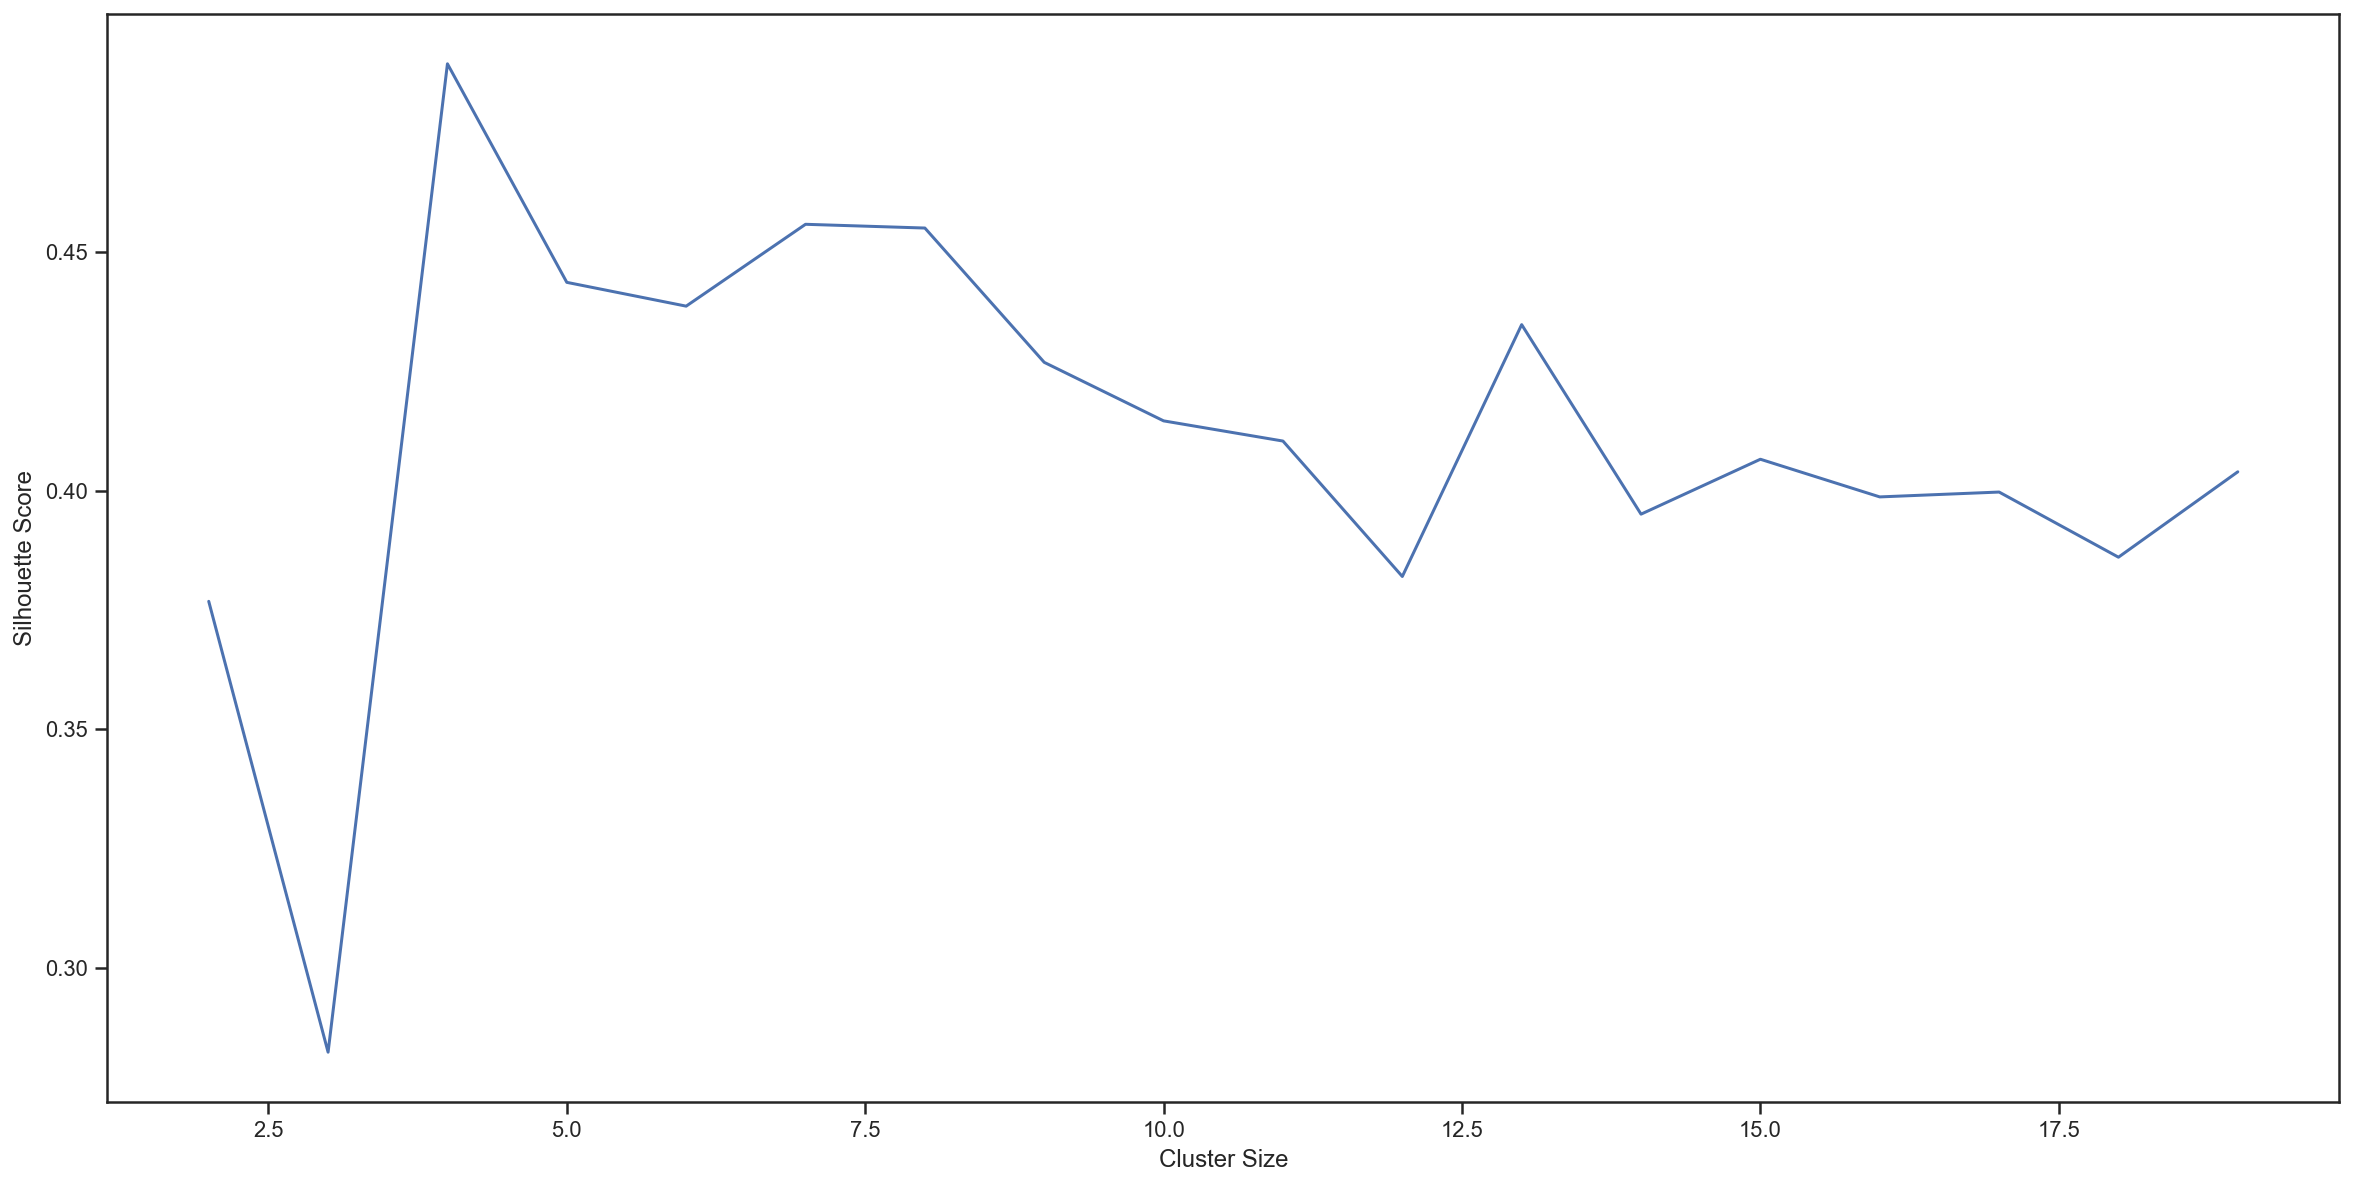

In [10]:
cluster_sizes = []
silhouettes = []

for i in range(2, 20):
    cluster_sizes.append(i)
    kmeans = KMeans(n_clusters=i, random_state=1024).fit(beer_vectors)
    silhouettes.append(silhouette_score(beer_vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
g = sns.lineplot(x=cluster_sizes, y=silhouettes)
g.set_xlabel("Cluster Size")
g.set_ylabel("Silhouette Score")

In [11]:
best_cluster_size = cluster_sizes[silhouettes.index(max(silhouettes))]
# best_cluster_size = 4
best_cluster_size

4

/usr/local/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


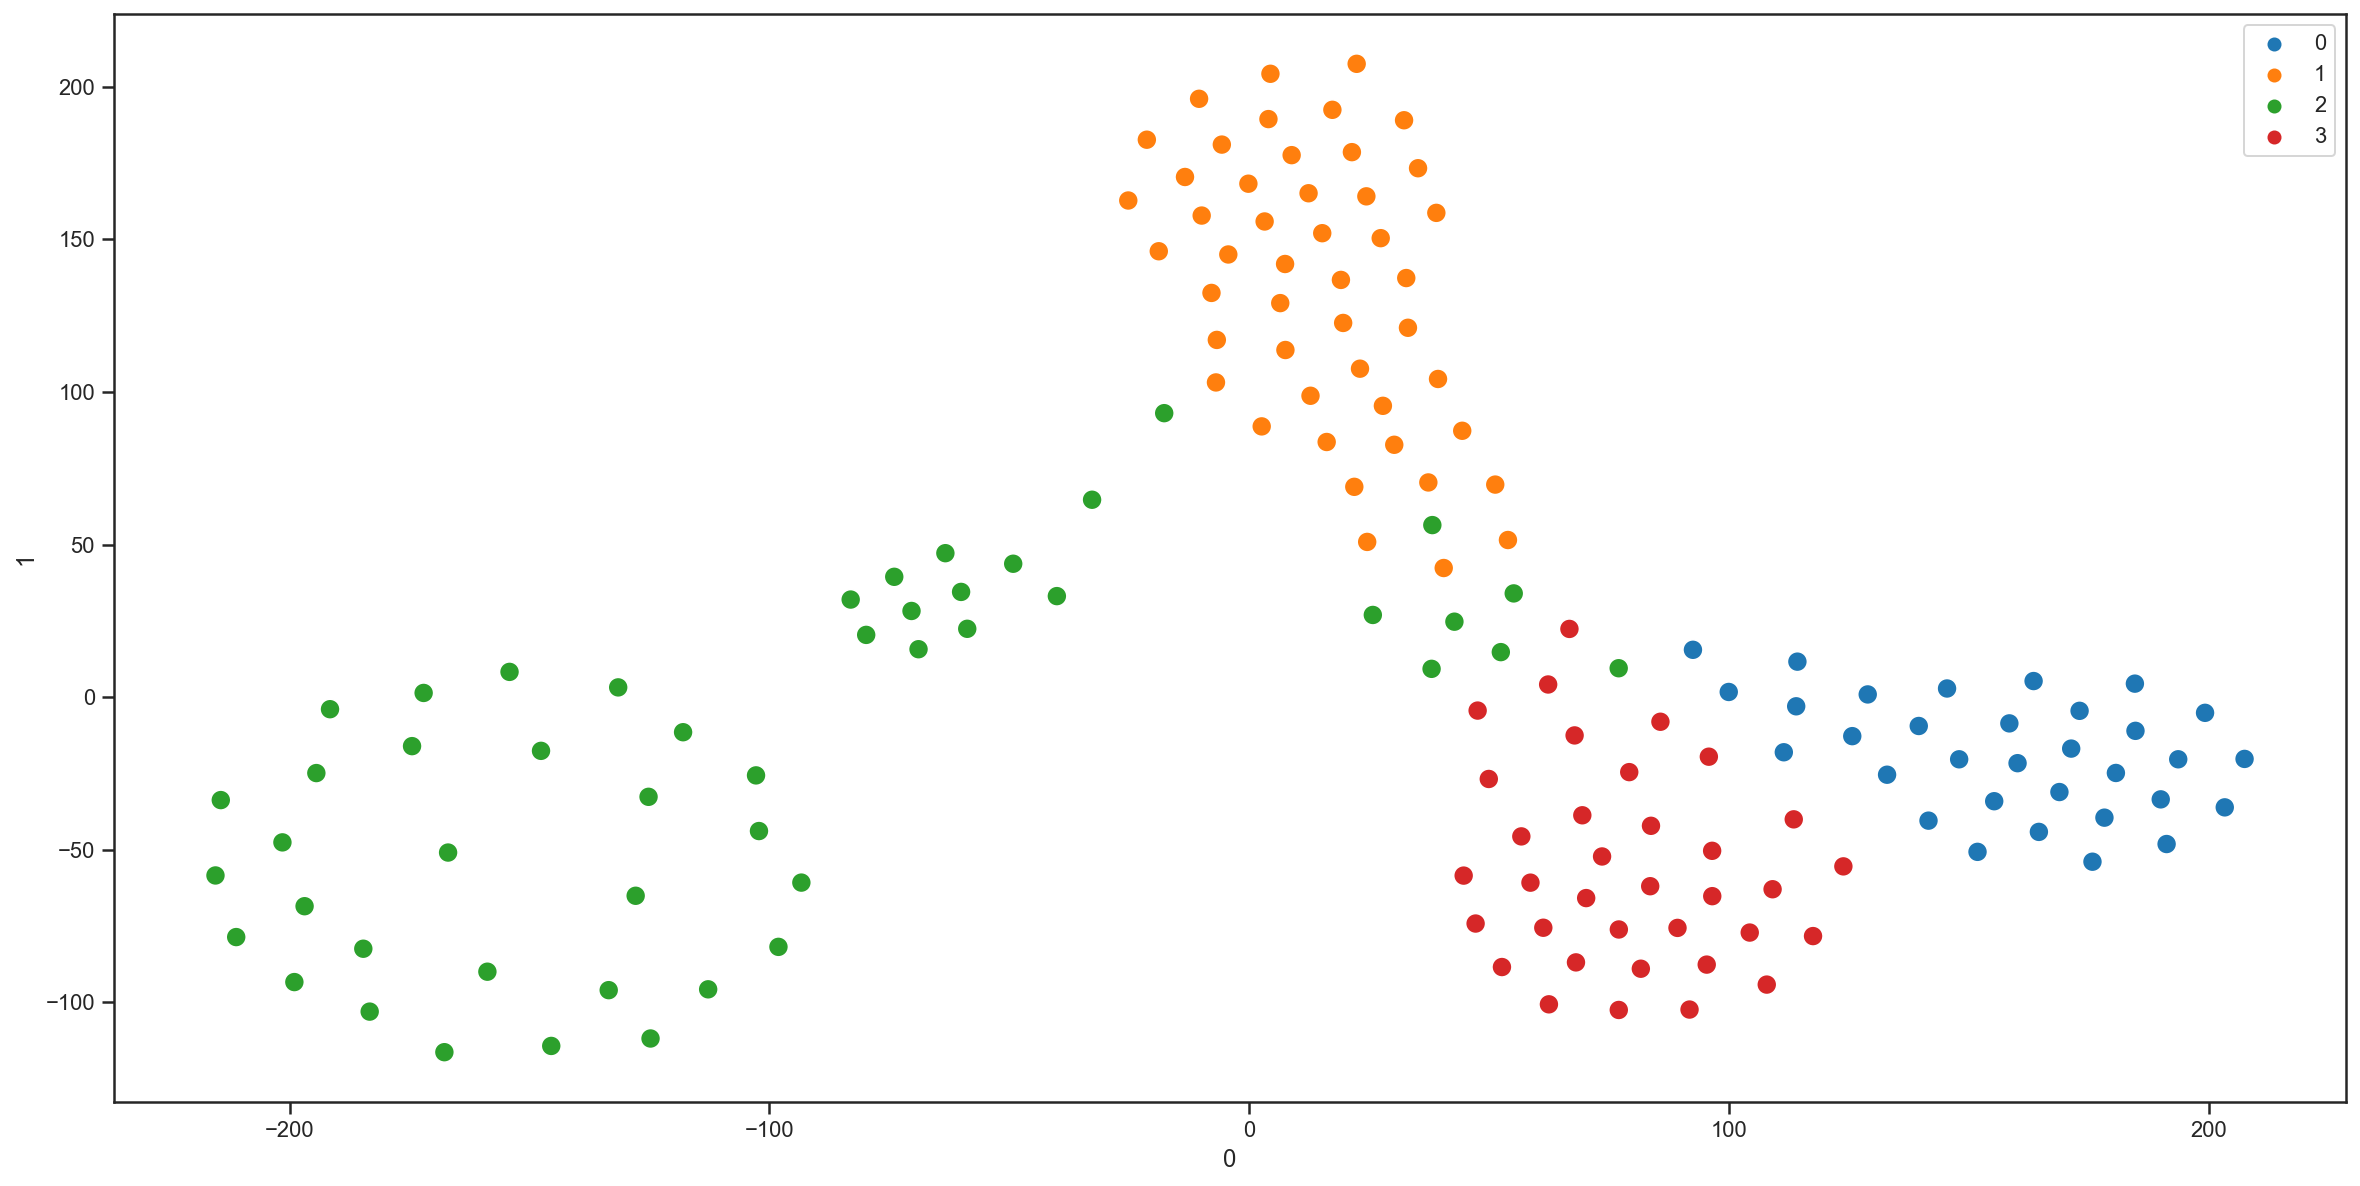

In [12]:
kmeans = KMeans(n_clusters=best_cluster_size, random_state=1024).fit(beer_vectors)

tsne = TSNE(n_components=2, metric="cosine", learning_rate=100, square_distances=True, init="pca",
            random_state=1024)
reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(beer_vectors)))
ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
plt.show()

In [13]:
cluster_attributes = {l : [] for l in set(kmeans.labels_)}
reduced["id"] = beer_ids
reduced["cluster_id"] = kmeans.labels_

for (i, row) in reduced.iterrows():
    attributes = list(df[df["id"] == row["id"]]["attribute"])
    cluster_attributes[row["cluster_id"]] += attributes

appearing_in_all = None
for cluster_id in cluster_attributes:
    if appearing_in_all is None:
        appearing_in_all = set(cluster_attributes[cluster_id])
    else:
        appearing_in_all = appearing_in_all.intersection(set(cluster_attributes[cluster_id]))
        
print(appearing_in_all)
    
{c : sorted(Counter([a for a in cluster_attributes[c] if a not in appearing_in_all]).items(), 
            key=lambda x : x[1], reverse=True) for c in cluster_attributes}

{'refermented', 'conditioned', 'hoppy', 'ale', 'lactose'}


{0: [('imperial', 26),
  ('stout', 22),
  ('milk', 20),
  ('vanilla', 17),
  ('imperial milk stout', 16),
  ('milk stout', 16),
  ('coffee', 12),
  ('cinnamon', 10),
  ('@rojosroastery', 9),
  ('madagascar vanilla', 8),
  ('tahitian vanilla', 7),
  ('maple', 6),
  ('maple syrup', 6),
  ('coconut', 6),
  ('syrup', 5),
  ('boiled', 5),
  ('imperial stout', 5),
  ('porter', 4),
  ('toasted coconut', 4),
  ('beans', 3),
  ('imperial milk porter', 3),
  ('milk porter', 3),
  ('toasted', 3),
  ('boiled overnight', 3),
  ('sweet', 3),
  ('cacao', 3),
  ('cacao nibs', 3),
  ('peppers', 3),
  ('organic', 2),
  ('autumnal', 2),
  ('imperial sweet stout', 2),
  ('spices', 2),
  ('conditioning', 2),
  ('hot', 2),
  ('hot peppers', 2),
  ('aged', 2),
  ('banana', 2),
  ('black walnut', 2),
  ('peanut', 2),
  ('bourbon', 2),
  ('vanilla beans', 2),
  ('vanilla bean', 1),
  ('confectionery', 1),
  ('untoasted', 1),
  ('sumatra', 1),
  ('pepper', 1),
  ('acid', 1),
  ('ascorbic', 1),
  ('citric', 1),


In [14]:
cluster_names = {0 : "Stouts", 1 : "IPAs", 2 : "Hoppy Ales", 3 : "Sours"}

In [15]:
reduced["cluster_name"] = reduced["cluster_id"].apply(lambda x : cluster_names[x])

In [16]:
reduced["attributes"] = reduced["id"].apply(lambda x : ", ".join(sorted(df[df["id"] == x]["attribute"])))
reduced

,0,1,id,cluster_id,cluster_name,attributes
0,-166.965698,-50.923897,0,2,Hoppy Ales,"ale, hoppy, hoppy ale"
1,-166.965698,-50.923897,1,2,Hoppy Ales,"ale, hoppy, hoppy ale"
2,-166.965698,-50.923897,2,2,Hoppy Ales,"ale, hoppy, hoppy ale"
3,-79.843521,20.401455,3,2,Hoppy Ales,"ale, honey, hoppy, hoppy ale"
4,-49.209812,43.712395,6,2,Hoppy Ales,"ale, hoppy, hoppy ale, lactose, peach, referme..."
...,...,...,...,...,...,...
218,-93.352425,-60.770096,318,2,Hoppy Ales,"ale, hoppy, hoppy ale"
219,-211.115936,-78.619240,319,2,Hoppy Ales,"ale, hoppy, hoppy ale"
220,-154.160843,8.276218,320,2,Hoppy Ales,"ale, hoppy, hoppy ale"
221,-127.878540,-65.086754,321,2,Hoppy Ales,"ale, hoppy, hoppy ale"


In [17]:
reduced.to_csv("troon_TSNE_kmeans_clusters.csv", index=False)